# Methods for Evenly-Spaced Random Sampling 

How should we initialise points to evaluate (expensive) models? We want to randomly sample the allowed region, but ideally not have points too close to one-another. This problem can be solved using [Quasi Monte Carlo (QMC) methods](https://en.wikipedia.org/wiki/Quasi-Monte_Carlo_method). Since July 2021 (i.e. v1.7), `scipy` has a [QMC submodule](https://docs.scipy.org/doc/scipy/reference/stats.qmc.html) with lots of method available. We'll comapre some of these methods here.

One complication is that out models have parameter constraints. Namely, we have inequality constraints on linear combinations of parameters, while QMC methods in `scipy` only sample on $[0,1]^d$. We can handle this with rejection sampling: take more points than we need, then exclude those that fall outside the constraints.

Before finding out about QMC, another solution I considered was an n-body simulation, where points emit a repulsive force from one another. Inequality constriants could be handled by reflecting off the walls. For comparison (and fun), I've implemented a simple n-body integrator to demo this idea.

In [1]:
import numpy as np
np.seterr(divide='ignore')
from scipy.spatial import distance
from scipy.stats import qmc
import matplotlib.pyplot as plt

np.random.seed(364354)

In [2]:
class EvenlySpacedRandomSampling():
    
    def __init__(self,
                 bounds,
                 A_ineq=None,
                 b_ineq=None):
        '''
        bounds = list of (lo,hi) tuples for each parameter x
        where x is the paramater vector of length n.        
        A_ineq and b_ineq are optionally a (m,n) matrix and (m,) vector
        defining inequality constraints `A_ineq x leq b_ineq`
        '''
        n_dim = len(bounds)
        self.n_dim = n_dim
        for bound0 in bounds:
            assert len(bound0)==2
            assert bound0[1]>bound0[0]
        self.bounds = bounds
        self.lo = np.array([b0[0] for b0 in bounds])
        self.hi = np.array([b0[1] for b0 in bounds])
        self.range = self.hi-self.lo
        A = np.zeros((2*n_dim, n_dim))
        b = np.zeros(2*n_dim)
        for i in range(n_dim):
            A[2*i,i] = -1
            b[2*i] = -self.lo[i]
            A[2*i+1,i] = 1
            b[2*i+1] = self.hi[i]
        if (A_ineq is None) and (b_ineq is None):
            pass
        else:
            n_ineq, n_dim2 = A_ineq.shape
            self.n_ineq = n_ineq
            assert n_dim2==n_dim
            A = np.vstack((A, A_ineq))
            assert len(b_ineq)==n_ineq
            b = np.concatenate((b, b_ineq))
        self.A = A
        self.b = b
        self.Aprime = np.matmul(A, np.diag(self.range))
        self.bprime = b - np.dot(A, self.lo)
        self.Aprime_nrm = (self.Aprime.T/distance.norm(self.Aprime, axis=1)).T

    def xprime_from_x(self, x):
        '''
        Transform points from co-ordinates with specified-bounds to [0,1]^n  
        '''
        xprime = np.einsum('ij,nj->nj', np.diag(1./self.range), x)
        xprime -= (self.lo/self.range)[np.newaxis,:]
        return xprime
    
    def x_from_xprime(self, xprime):
        '''
        Transform points from [0,1]^n to co-ordinates with specified-bounds
        '''
        x = np.einsum('ij,nj->nj', np.diag(self.range), xprime)
        x += self.lo[np.newaxis,:]
        return x
    
    def uniform_sample_with_rejection(self, n, factor_per_iter=10, n_max_iter=10):
        '''
        Uniform sampling in [0,1] with rejection outside the contraints
        '''
        n_samples = 0
        samples = np.zeros((n_samples, self.n_dim))
        i_iter = 0
        n_tmp = factor_per_iter*n
        while (i_iter<n_max_iter) and (n_samples<n):
            tmp = np.random.uniform(size=(n_tmp, self.n_dim))
            is_valid = self.check_if_valid(tmp)
            samples = np.vstack((samples, tmp[is_valid, :]))
            i_iter += 1
            n_samples = samples.shape[0]
        if n_samples<n:
            raise ValueError('Not enough samples created. Increase factor_per_iter or n_max_iter')
        else:
            samples = samples[:n, :]
        samples = self.x_from_xprime(samples)
        return samples
    
    def step(self,
             xp,
             force_power_law=-2,
             tstep=0.001,
             reflect_boost=2.,
             kw_rejection_sample={}):
        '''
        A step for the n-body integrator
        '''
        n_particle = xp.shape[0]
        # square matrix of mutual (repulsive) forces
        dist = distance.pdist(xp)
        dist = distance.squareform(dist)
        force = dist**force_power_law
        np.fill_diagonal(force, 0.)
        # (n,n,n_dim) matrix of normed mutual offsets
        offset = xp[np.newaxis,:,:] - xp[:,np.newaxis,:]
        tmp = 1.*dist
        np.fill_diagonal(tmp, np.inf)
        normed_offset = offset/tmp[:,:,np.newaxis]
        # velocity = summed mututal forces
        # square matrix counts mutual forces twice, so half this
        velocity = normed_offset * force[:,:,np.newaxis]
        velocity = 0.5 * np.sum(velocity, axis=0)
        # update position 
        xpnew = xp + tstep * velocity
        # find particles with have escaped boundary in this timesep
        # these will satisfy A'(x' + f*t_step*v) - b' = 0 for some 0<f<1
        # i.e. y + fz = 0 for y = A'x' - b' and z = t_step * A'v
        y = np.einsum('cd,nd->nc', self.Aprime, xp) - self.bprime
        z = tstep * np.einsum('cd,nd->nc', self.Aprime, velocity)
        f = -y/z
        # relect particle off whichever boundary is crossed first
        # i.e. find the crossing with minimum f for 0<f<1
        f[f<0] = np.inf
        f[f>1] = np.inf
        argmin_f = np.argmin(f, axis=1)
        min_f = f[np.arange(n_particle), argmin_f]
        idx = np.where(min_f < np.inf)
        # for the reflected velocity flip the sign of velocity...
        # ... component perpendicular to boundary wall
        v_cmp_perp = np.einsum('ij,ij->i',
                               self.Aprime_nrm[argmin_f[idx],:],
                               velocity[idx])
        v_cmp_perp = (v_cmp_perp * self.Aprime_nrm[argmin_f[idx],:].T).T
        v_cmp_par = velocity[idx] - v_cmp_perp
        # add a boost to the reflected perpendicular velocity to prevent bunching up at edges
        v_reflected = v_cmp_par - reflect_boost * v_cmp_perp
        # for particles which have crossed boundary (ie subscript `idx`)
        # replace their positions with the reflected version which traveled 
        # with original/reflected velocity for fractions f/(1-f) of the timesetep
        xpnew[idx] = xp[idx] + tstep * (min_f[idx]*velocity[idx].T + (1-min_f[idx])*v_reflected.T).T
        # corner particles may still not be valid
        # since their reflected positions may be outside a second boundary
        # replace these (hopefully few) instances with rehection samples
        is_valid = self.check_if_valid(xpnew)
        idx_not_valid = np.where(is_valid==False)
        n_not_valid = len(idx_not_valid[0])
        fraction_not_valid = n_not_valid/xp.shape[0]
        rejection_sampled = self.uniform_sample_with_rejection(n_not_valid, **kw_rejection_sample)
        xpnew[idx_not_valid] = rejection_sampled
        return xpnew, fraction_not_valid
    
    def check_if_valid(self, xp):
        '''
        Check if a (primed i.e. in [0,1]) poistion is within the constrained region
        '''
        is_valid = np.matmul(self.Aprime, xp.T).T <= self.bprime
        is_valid = np.prod(is_valid, axis=1, dtype=bool)
        return is_valid
    
    def calibrate_tstep(self,
                        n_part,
                        tstep_init=1e-4,
                        n_max_iter=10,
                        reflect_boost=2.,
                        factor_reduce_tsep_per_init=5.,
                        n_steps=30,
                        target_invalid_frac=0.01,
                        kw_rejection_sample={},
                        kw_step={}
                        ):
        '''
        Calibrate the timestep so that only a small fraction `target_invalid_frac`
        of particles are sent outside the constrained region
        '''
        i_iter = 0
        avg_fraction_not_valid = 1.
        tstep = factor_reduce_tsep_per_init * tstep_init
        while (avg_fraction_not_valid > target_invalid_frac) and (i_iter < n_max_iter):
            tstep = tstep/factor_reduce_tsep_per_init
            tmp = []
            xpnew = self.uniform_sample_with_rejection(n_part, **kw_rejection_sample)
            for i in range(n_steps):
                xpnew, fraction_not_valid = self.step(xpnew,
                                                      tstep=tstep,
                                                      **kw_step)
                tmp += [fraction_not_valid]
            avg_fraction_not_valid = np.mean(tmp)
            i_iter += 1
        return tstep, avg_fraction_not_valid, i_iter
        
    def sample_nbody(self,
                     n_part=100,
                     kw_rejection_sample={},
                     kw_step={},
                     n_steps=100):
        '''
        Main sampling method 
        '''
        tstep, _, _ = self.calibrate_tstep(n_part)
        x_steps = np.zeros((n_steps, n_part, self.n_dim))
        xnew = self.uniform_sample_with_rejection(n_part, **kw_rejection_sample)
        xpnew = self.xprime_from_x(xnew)
        for i in range(n_steps):
            x_steps[i] = self.x_from_xprime(xpnew)
            xpnew, _ = self.step(xpnew, tstep=tstep, **kw_step)
        return x_steps

    def get_min_dist(self, xp):
        '''
        Get array of distances to nearest neighbour
        '''
        dist = distance.pdist(xp)
        dist = distance.squareform(dist)
        dist[dist==0] = np.inf
        min_dist = np.min(dist, axis=0)
        return min_dist
    
    def sample_with_scipy_qmc(self, n_part=100, method='Sobol', max_iter=100):
        '''
        Use scipy's QMC methods to sample in [0,1]^n, rejecting those 
        outside constraints, increasing the number of trials till the 
        desired number of samples remains
        '''        
        n_valid = 0
        n_trial = 1*n_part
        i_iter = 0
        while (n_valid<n_part) and (i_iter < max_iter):
            if method=='Sobol':
                sampler = qmc.Sobol(d=self.n_dim, scramble=True)
            elif method=='Halton':
                sampler = qmc.Halton(d=self.n_dim, scramble=True)
            elif method=='LatinHypercube':
                sampler = qmc.LatinHypercube(d=self.n_dim)
            sample = sampler.random(n=n_trial)
            is_valid = self.check_if_valid(sample)
            sample = sample[is_valid]
            n_valid = sample.shape[0]
            n_trial = int(n_trial*1.1)
            i_iter += 1
        # if there are extra points, remove the ones with nearest neighbours
        min_dist = self.get_min_dist(sample)
        sample = sample[np.argsort(min_dist)[-n_part:], :]
        sample = self.x_from_xprime(sample)
        return sample

## A 2D example

In [3]:
esrs = EvenlySpacedRandomSampling(
    [(0,0.5), (0,1)],
    A_ineq=np.array([[1,-1]]),
    b_ineq=np.array([0])
)

First the simplest random sampling: uniform in $[0,1]^n$ with rejection sampling to exclude points outside the constriants,

In [4]:
n_particles = 300
x = esrs.uniform_sample_with_rejection(n_particles)

In [5]:
def plot_2d_example(x, isgif=False):
    plt.plot(*x.T, '.k')
    plt.axvline(0, ls=':')
    plt.axvline(0.5, ls=':')
    plt.plot([0,0.5], [0,0.5], ls=':')
    plt.axhline(1, ls=':')
    return

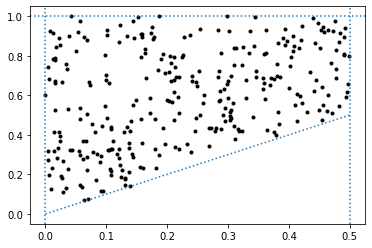

In [6]:
plot_2d_example(x)

Next let's compare some of the methods available in `scipy.stats.qmc`,

/Users/pjethwa/miniconda3/envs/base_py39/lib/python3.9/site-packages/scipy/stats/_qmc.py:1078: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"


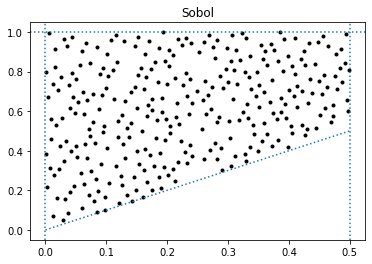

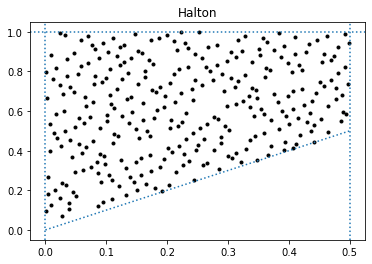

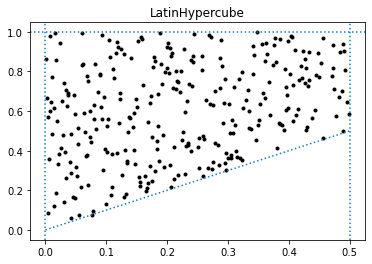

In [7]:
for method in ['Sobol', 'Halton', 'LatinHypercube']:
    x_sobol = esrs.sample_with_scipy_qmc(n_particles, method=method)
    plot_2d_example(x_sobol)
    plt.gca().set_title(method)
    plt.show()

The LatinHypercube does not look as good as Sobol or Halton.

Next try the n-body simulation,

In [8]:
n_steps = 30
xsteps = esrs.sample_nbody(
    n_part=n_particles,
    n_steps=n_steps
)

In [9]:
import imageio
import os

def gif_2d_example(xsteps, outfile='mygif.gif'):
    n_steps, _, _ = xsteps.shape
    filenames = []
    for i in range(n_steps):
        x = xsteps[i]
        plot_2d_example(x)
        fig = plt.gcf()
        filename = f'{i}.png'
        filenames.append(filename)
        plt.savefig(filename)
        plt.close()
    # build gif
    with imageio.get_writer(outfile, mode='I') as writer:
        for f0 in filenames:
            image = imageio.imread(f0)
            writer.append_data(image)
    # Remove files
    for f0 in set(filenames):
        os.remove(f0)
    return

In [10]:
gif_2d_example(xsteps, outfile='example_2d.gif')

<img src="example_2d.gif" align="center">

The particles bunch up against the walls. Though they are reflected, they seem to be pinned to the edges by the repulsion of all other particles. We could maybe fix this by boosting the velocities of the particles when they are reflected off the walls. Here by a factor of ten,

In [11]:
n_steps = 30
xsteps = esrs.sample_nbody(
    n_part=n_particles,
    n_steps=n_steps,
    kw_step={'reflect_boost':10.}    
)

In [12]:
gif_2d_example(xsteps, outfile='example_2d_boost.gif')

<img src="example_2d_boost.gif" align="center">

To compare these quantitatively, we can look at the distribution of distances from each particles to its nearest neighbour,

/Users/pjethwa/miniconda3/envs/base_py39/lib/python3.9/site-packages/scipy/stats/_qmc.py:1078: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"


Text(0.5, 1.0, 'Distribution of Distance to Nearest Neighbours')

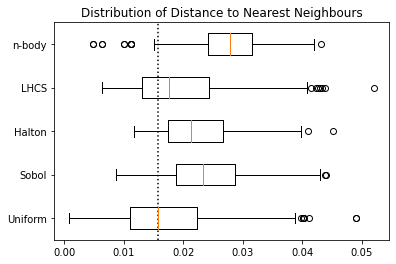

In [13]:
x = esrs.uniform_sample_with_rejection(n_particles)
min_dist_unif = esrs.get_min_dist(x)
x = esrs.sample_with_scipy_qmc(n_particles, method='Sobol')
min_dist_sobol = esrs.get_min_dist(x)
x = esrs.sample_with_scipy_qmc(n_particles, method='Halton')
min_dist_halton = esrs.get_min_dist(x)
x = esrs.sample_with_scipy_qmc(n_particles, method='LatinHypercube')
min_dist_lhcs = esrs.get_min_dist(x)
# for n-body take the last snapshot of the previous simulation
min_dist_nbody = esrs.get_min_dist(xsteps[-1])

x = [min_dist_unif,
     min_dist_sobol,
     min_dist_halton,
     min_dist_lhcs,
     min_dist_nbody]
labels=['Uniform',
        'Sobol',
        'Halton',
        'LHCS',
        'n-body']
_ = plt.boxplot(x, labels=labels, vert=False, meanline=False)
plt.axvline(np.median(min_dist_unif), ls=':', color='k')
plt.gca().set_title('Distribution of Distance to Nearest Neighbours')

As we saw visually above, it appears that latin hypercube sampling is no better than uniform random. This may be a cosequence of using rejection sampling to impose the ineuqality constraints.

Note there is a paper about [Latin hypercube sampling with inequality constraints](https://arxiv.org/abs/0909.0329), which presents a method to permute a LHC sample to satisfy linear inequalities while retaining the LHCS property. How well would this work? Figure 4 of that paper suggests to me that the perutations will lead to samples bunching up against the inequality.

I don't think it is worth looking into LHCS further, as Halton and Sobal produce better results. The best result here is from the n-body code.

## A 7D example

Our modelling problem has 7 parameters which must satisfy 4 inequality constraints. The exact parameter ranges and the form of the inqualites depend on other hyper-parameters, which can change from problem instance to instance. Hence here, we will test the sampling methods with a *representative* 7D space with 4 constraints,

In [14]:
esrs = EvenlySpacedRandomSampling(
    [(0,1)]*7,
    A_ineq=np.array([
        [1,-1,0,0,0,0,0],
        [1,0,-1,0,0,0,0],
        [0,0,0,0,0,1,-1],
        [0,0,0,0,1,0,-1],
    ]),
    b_ineq=np.array([0,0,0,0])
)

Get the nearest neighbour distances for each of the methods,

/Users/pjethwa/miniconda3/envs/base_py39/lib/python3.9/site-packages/scipy/stats/_qmc.py:1078: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"


Text(0.5, 1.0, 'Distribution of Distance to Nearest Neighbours')

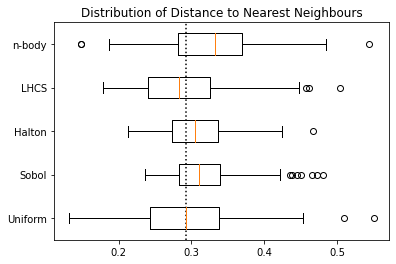

In [15]:
x = esrs.uniform_sample_with_rejection(n_particles)
min_dist_unif = esrs.get_min_dist(x)
x = esrs.sample_with_scipy_qmc(n_particles, method='Sobol')
min_dist_sobol = esrs.get_min_dist(x)
x = esrs.sample_with_scipy_qmc(n_particles, method='Halton')
min_dist_halton = esrs.get_min_dist(x)
x = esrs.sample_with_scipy_qmc(n_particles, method='LatinHypercube')
min_dist_lhcs = esrs.get_min_dist(x)

# For the n-body simulation, let's take more steps
# to let things diffuse suffieciently,

n_steps = 1000
xsteps = esrs.sample_nbody(
    n_part=n_particles,
    n_steps=n_steps,
    kw_step={'reflect_boost':10.}    
)
min_dist_nbody = esrs.get_min_dist(xsteps[-1])

x = [min_dist_unif,
     min_dist_sobol,
     min_dist_halton,
     min_dist_lhcs,
     min_dist_nbody]
labels=['Uniform',
        'Sobol',
        'Halton',
        'LHCS',
        'n-body']
_ = plt.boxplot(x, labels=labels, vert=False, meanline=False)
plt.axvline(np.median(min_dist_unif), ls=':', color='k')
plt.gca().set_title('Distribution of Distance to Nearest Neighbours')

Again, LHCS looks like it is hardly better than random. N-body produces the best median result, however it gives a long left-tail compared to Sobol and Halton. This is quite sensitive to how we pick the *releftion boost* parameter. While N-body has perfrmed well overall, with relatively little tuning, perhaps it is better to go with more tried-and-trusted approaches.

Sobol and Halton are somewhat better than uniform in their median nearest neighbour diatnces, however with significantly shorter left tails. Eihter would be a reasonable choice.